In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import time
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc,f1_score

In [1]:
# @title
# Define helper functions
# All models in the voting ensemble classifier are fine tuned by using grid search with cv = 5
def voting_classification_model(X,y,test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Create individual classifiers
    rf = RandomForestClassifier(n_estimators=80,max_depth = 10, min_samples_split = 40, random_state=42)
    xgb_model = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 200, random_state=42)
    adaboost = AdaBoostClassifier(learning_rate = 0.1, n_estimators = 150, random_state=42)
    lgbm = LGBMClassifier(learning_rate = 0.1, n_estimators = 150, max_depth = 7, num_leaves = 31, random_state=42)

    rf.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    adaboost.fit(X_train, y_train)
    lgbm.fit(X_train, y_train)

    # Create the voting classifier
    voting_classifier = VotingClassifier(estimators=[
        ('rf', rf),
        ('xgb', xgb_model),
        ('adaboost', adaboost),
        ('lgbm', lgbm)
    ], voting='soft')

    # Train the voting classifier on the training data
    voting_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = voting_classifier.predict(X_test)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_voting_model = f1_score(y_test, y_pred)
    print(f"Voting Classifier Test Accuracy: {accuracy:.4f}")
    print(f"Voting Classifier F1 Score: {f1_score_voting_model:.4f}")
    # Retrieve feature importances from each base classifier
    rf_feature_importances = rf.feature_importances_
    xgb_feature_importances = xgb_model.feature_importances_
    ada_feature_importances = adaboost.feature_importances_
    lgbm_feature_importances = lgbm.feature_importances_
    importance_sum = sum(lgbm.feature_importances_)
    normalized_importances = lgbm.feature_importances_ / importance_sum
    # Combine the feature importances by taking the average or sum
    ensemble_feature_importances = (rf_feature_importances + xgb_feature_importances + ada_feature_importances + normalized_importances) / 4

    # Create a DataFrame to visualize the feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': ensemble_feature_importances
    })

    # Sort the features by importance (descending)
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

    #confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred)

    # Predict probabilities on the test set
    y_probs = voting_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    #

    #misclassified_samples
    misclassified_samples = X_test[y_test != y_pred].index.to_list()

    return voting_classifier, fpr, tpr, roc_auc,cm,feature_importance_df,accuracy,misclassified_samples,f1_score_voting_model
#confusion matrix plot
def cf_plot(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['True Low', 'True High'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
def roc_plot(fpr,tpr,roc_auc):
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def get_misclassifed_rows(full_df,index_list,sample_count=3,full_list = False):
    misclassified_rows = full_df[full_df.index.isin(index_list)]
    if full_list == True :
        return misclassified_rows
    else: return misclassified_rows.sample(sample_count)[['headline','body',' shares','share_cat']]

In [3]:
#load engineered data
drive.mount('/content/gdrive')
!cp '/content/gdrive/MyDrive/W266/data/feature_eng_df.csv' -d /content
df = pd.read_csv('feature_eng_df.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


create different dataset base on features

In [4]:
# @title
X_new = df[[
 'org_shares',
 'event_shares',
 'person_shares',
 'date_shares',
 'loc_shares',
 'kw_2_shares',
 'kw_3_shares',
 'kw_1_shares',
 'topic_shares']]
X_new_cat = df[[' is_weekend'
#,
# 'title_sentiment_Negative_x',
# 'title_sentiment_Neutral_x',
# 'title_sentiment_Positive_x'
]]
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)
X_new_scaled = pd.DataFrame(X_new_scaled, columns=X_new.columns)
X_new_scaled = pd.merge(X_new_scaled,X_new_cat,right_index=True, left_index=True)
y = df['share_cat']

X_org = df[[' timedelta',
 ' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' max_positive_polarity',
 ' avg_negative_polarity',
 ' min_negative_polarity',
 ' max_negative_polarity',
 ' title_subjectivity',
 ' title_sentiment_polarity',
 ' abs_title_subjectivity',
 ' abs_title_sentiment_polarity']]

X_full = df[[' timedelta',
 ' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' max_positive_polarity',
 ' avg_negative_polarity',
 ' min_negative_polarity',
 ' max_negative_polarity',
 ' title_subjectivity',
 ' title_sentiment_polarity',
 ' abs_title_subjectivity',
 ' abs_title_sentiment_polarity',
 'org_shares',
 'event_shares',
 'person_shares',
 'date_shares',
 'loc_shares',
 'kw_2_shares',
 'kw_3_shares',
 'kw_1_shares',
 'topic_shares']]

In [5]:
model_new = voting_classification_model(X_new_scaled,y,test_size=0.2)

Voting Classifier Test Accuracy: 0.7976
Voting Classifier F1 Score: 0.8240


In [6]:
model_org = voting_classification_model(X_org,y,test_size=0.2)

Voting Classifier Test Accuracy: 0.6809
Voting Classifier F1 Score: 0.6841


In [7]:
model_full = voting_classification_model(X_full,y,test_size=0.2)

Voting Classifier Test Accuracy: 0.8371
Voting Classifier F1 Score: 0.8498


Model result summary:

Model Name                             | Accuracy      | F1 Score
---------------------------------------|---------------|----------
Origional Features - Baseline Model    | 0.6809        | 0.6841
New Engineered Features Model          | 0.7976        | 0.8240
Combined Features Model                | 0.8371        | 0.8498

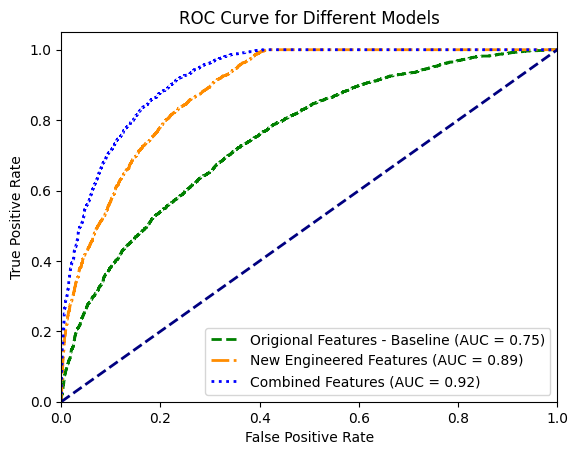

In [8]:
# Plot ROC Curves for each model on the same axes
plt.figure()
plt.plot(model_org[1], model_org[2], color='green', lw=2, linestyle = 'dashed',label='Origional Features - Baseline (AUC = {:.2f})'.format(model_org[3]))
plt.plot(model_new[1], model_new[2], color='darkorange', lw=2, linestyle = 'dashdot', label='New Engineered Features (AUC = {:.2f})'.format(model_new[3]))
plt.plot(model_full[1], model_full[2], color='blue', lw=2, linestyle = 'dotted',label='Combined Features (AUC = {:.2f})'.format(model_full[3]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.show()

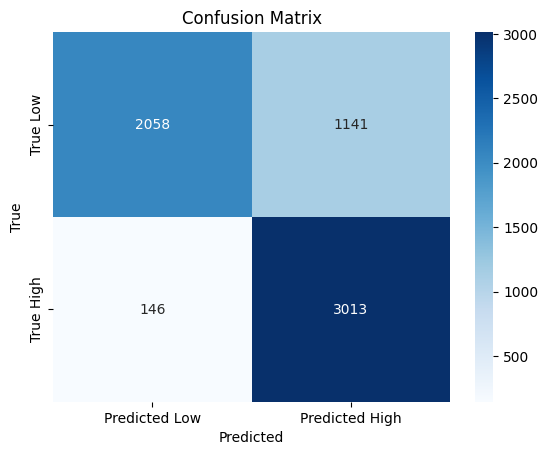

In [9]:
cf_plot(model_new[4])

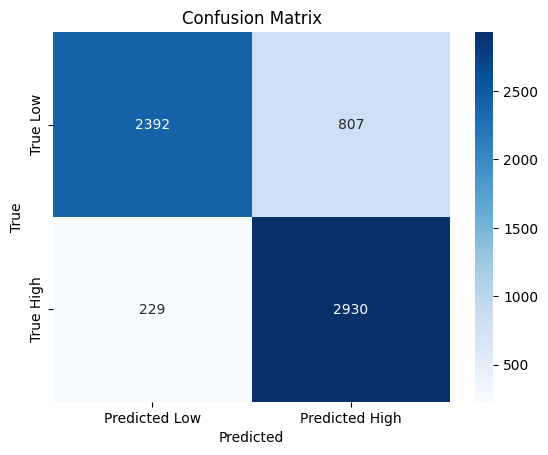

In [10]:
cf_plot(model_full[4])

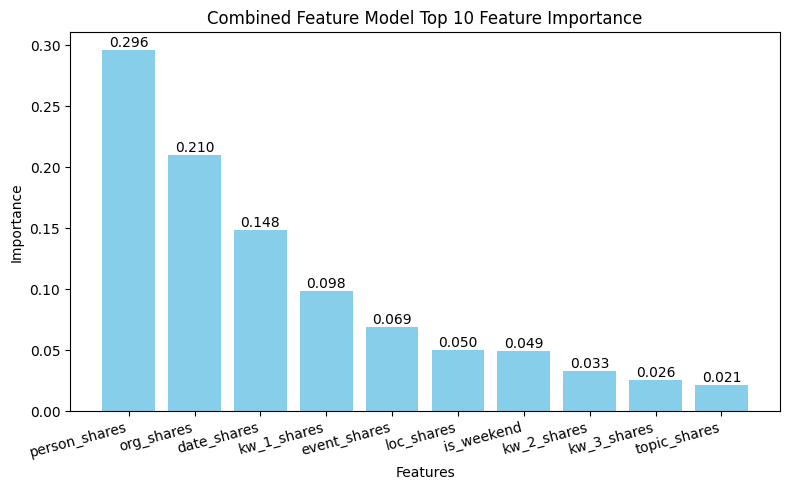

In [11]:
plt.figure(figsize=(8, 5))
bars = plt.bar(model_new[5]['Feature'], model_new[5]['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Combined Feature Model Top 10 Feature Importance')
plt.xticks(rotation=15, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

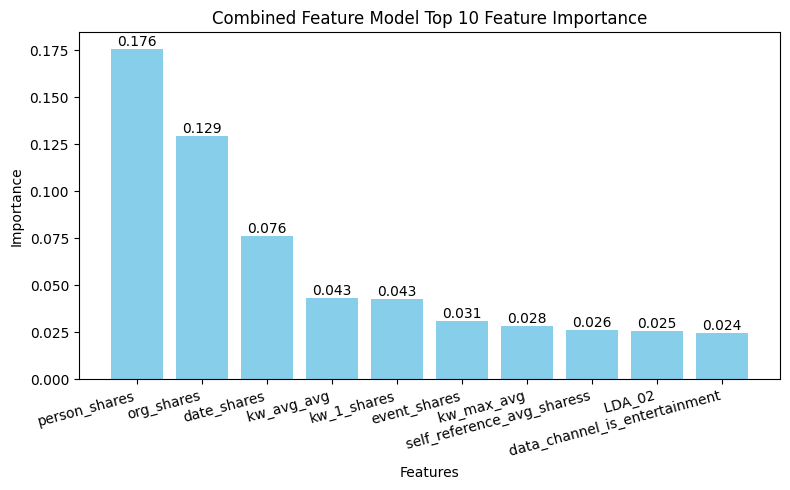

In [12]:
plt.figure(figsize=(8, 5))
bars = plt.bar(model_full[5]['Feature'], model_full[5]['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Combined Feature Model Top 10 Feature Importance')
plt.xticks(rotation=15, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
model_new_missed_df = get_misclassifed_rows(df,model_new[7],sample_count=3,full_list = True)
model_new_missed_df['share_cat_pred'] = list(map(lambda x: 1 if x == 0 else 0, model_new_missed_df['share_cat']))

<ipython-input-13-76587a44aa98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_new_missed_df['share_cat_pred'] = list(map(lambda x: 1 if x == 0 else 0, model_new_missed_df['share_cat']))


In [14]:
model_new_missed_df.groupby(['key_word_1'])['share_cat_pred'].sum().sort_values(ascending=False)

key_word_1
na           231
Google        37
Twitter       28
Facebook      20
Time          13
            ... 
##eri          0
##rump         0
Shell          0
##diction      0
Cuba           0
Name: share_cat_pred, Length: 512, dtype: int64

In [15]:
model_new_missed_df.sample(3)[['headline','org','person','key_word_1','key_word_2','key_word_3','org_shares','kw_1_shares','kw_2_shares']]

,headline,org,person,key_word_1,key_word_2,key_word_3,org_shares,kw_1_shares,kw_2_shares
6625,6 Apps You Don't Want To Miss,Mashable,0,na,na,na,457,16.0,22.0
23573,The Movies People Will Be Talking About at the...,0,0,People,Festival,Film,48,60.0,0.0
4949,Shed Light on Your Cooking With This Phosphor ...,0,0,na,na,na,48,16.0,22.0


In [16]:
model_new_missed_df.groupby(['person'])['share_cat_pred'].sum().sort_values(ascending=False)

person
0                692
Barack Obama       7
Stewart            6
Obama              6
Williams           5
                ... 
Kanye West         1
LeBron James       0
Perry              0
Jimmy Kimmel       0
Kevin Systrom      0
Name: share_cat_pred, Length: 331, dtype: int64

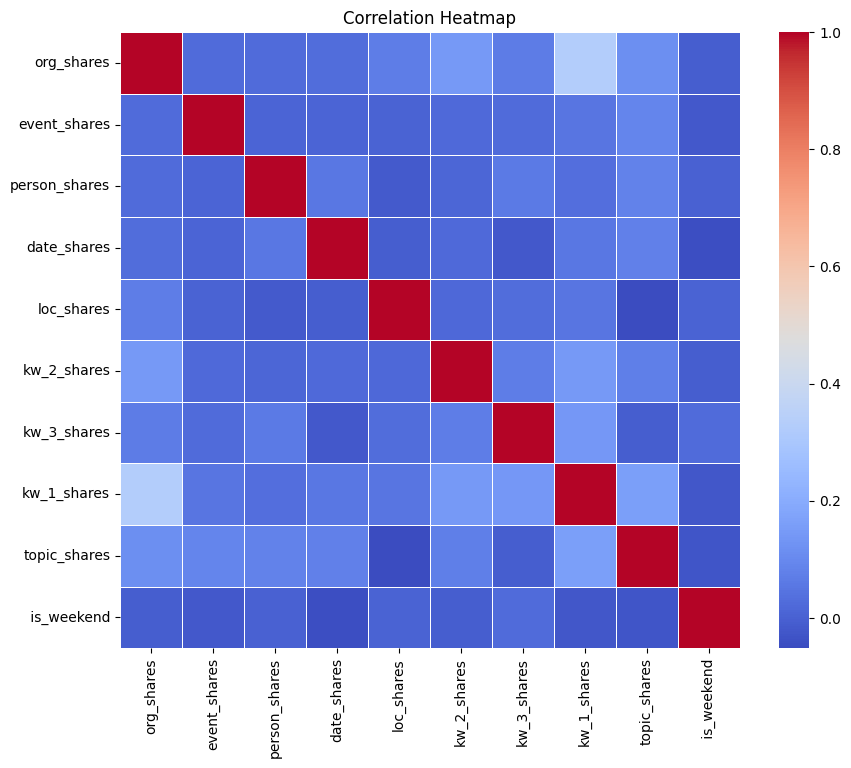

In [17]:
# Select numerical features for the heatmap
numerical_features = X_new_scaled.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
person_share = df[['person','person_shares']].sort_values(by = 'person_shares',ascending = False).drop_duplicates()
person_count =  df.groupby('person')['share_cat'].count()
person_df = pd.merge(person_share,person_count,left_on = 'person',right_index = True)
person_df['correct_perc'] = person_df['person_shares']/person_df['share_cat']
person_df_freq = person_df[person_df['share_cat']>=3]
(person_df[person_df['correct_perc'] >= 0.8].shape[0] + person_df[person_df['correct_perc'] == 0].shape[0]) /len(person_df)

0.8708495040965933

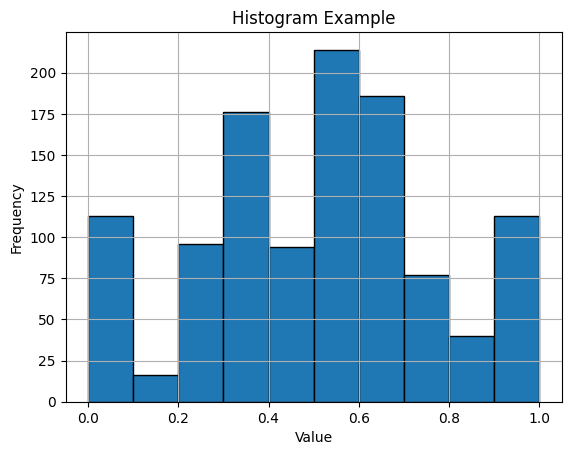

In [19]:

plt.hist(person_df_freq['correct_perc'], bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
plt.grid(True)
plt.show()

In [20]:
org_share = df[['org','org_shares']].sort_values(by = 'org_shares',ascending = False).drop_duplicates()
org_count =  df.groupby('org')['share_cat'].count()
org_df = pd.merge(org_share,org_count,left_on = 'org',right_index = True)
org_df['correct_perc'] = org_df['org_shares']/org_df['share_cat']
(org_df[org_df['correct_perc'] >= 0.8].shape[0] + org_df[org_df['correct_perc'] == 0].shape[0]) /len(org_df)

0.8551884732935526

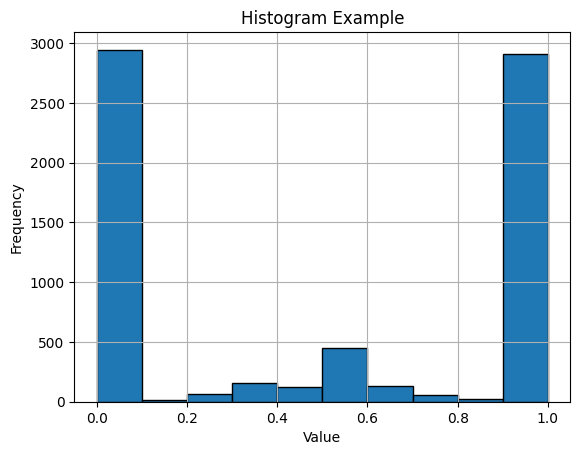

In [21]:
plt.hist(org_df['correct_perc'], bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
plt.grid(True)
plt.show()

In [22]:
loc_share = df[['loc','loc_shares']].sort_values(by = 'loc_shares',ascending = False).drop_duplicates()
loc_count =  df.groupby('loc')['share_cat'].count()
loc_df = pd.merge(loc_share,loc_count,left_on = 'loc',right_index = True)
loc_df['correct_perc'] = loc_df['loc_shares']/loc_df['share_cat']
(loc_df[loc_df['correct_perc'] >= 0.7].shape[0] + loc_df[loc_df['correct_perc'] == 0].shape[0]) /len(loc_df)

0.8380829015544041

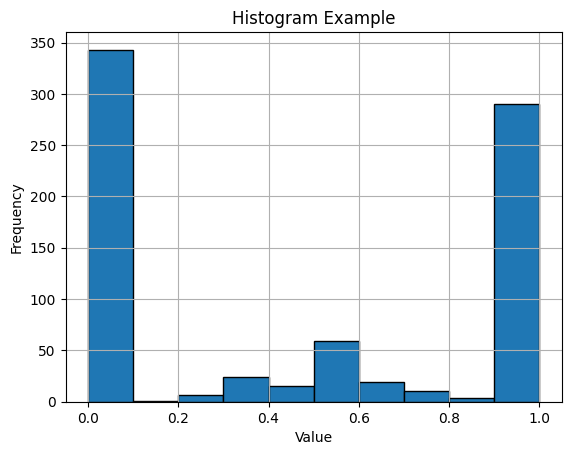

In [23]:
plt.hist(loc_df['correct_perc'], bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
plt.grid(True)
plt.show()

In [24]:
date_share = df[['date','date_shares']].sort_values(by = 'date_shares',ascending = False).drop_duplicates()
date_count =  df.groupby('date')['share_cat'].count()
date_df = pd.merge(date_share,date_count,left_on = 'date',right_index = True)
date_df['correct_perc'] = date_df['date_shares']/date_df['share_cat']
(date_df[date_df['correct_perc'] >= 0.7].shape[0] + date_df[date_df['correct_perc'] == 0].shape[0]) /len(date_df)

0.8080657206870799

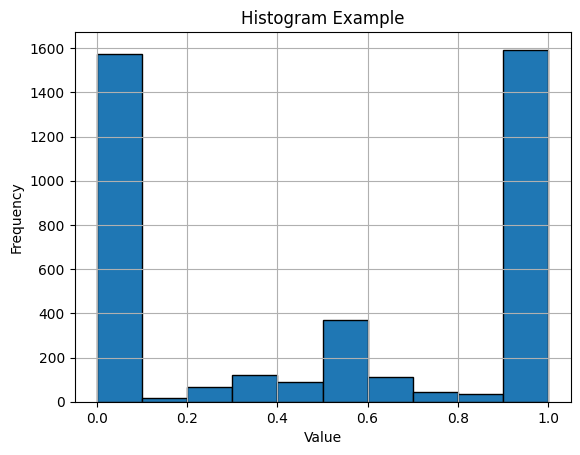

In [25]:
plt.hist(date_df['correct_perc'], bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
plt.grid(True)
plt.show()

In [26]:
event_share = df[['event','event_shares']].sort_values(by = 'event_shares',ascending = False).drop_duplicates()
event_count =  df.groupby('event')['share_cat'].count()
event_df = pd.merge(event_share,event_count,left_on = 'event',right_index = True)
event_df['correct_perc'] = event_df['event_shares']/event_df['share_cat']
(event_df[event_df['correct_perc'] >= 0.7].shape[0] + event_df[event_df['correct_perc'] == 0].shape[0]) /len(event_df)

0.8679085520745131

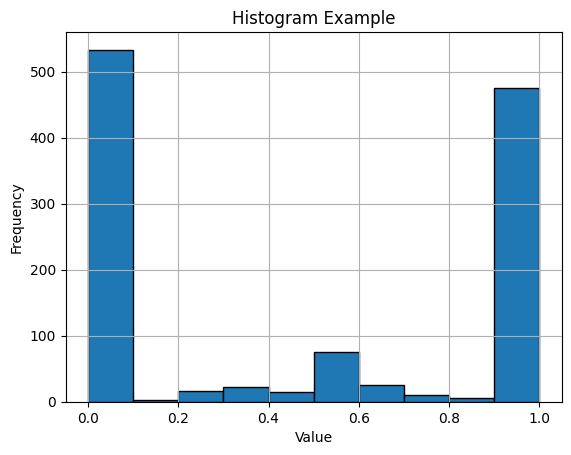

In [27]:
plt.hist(event_df['correct_perc'], bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
plt.grid(True)
plt.show()

In [28]:
df[['org','org_shares']].sort_values(by = 'org_shares',ascending = False).drop_duplicates()[:20]

,org,org_shares
10375,Apple,637
5462,Facebook,617
22264,Twitter,462
6028,Mashable,457
15964,Google,448
27325,YouTube,334
7340,Microsoft,220
29103,Instagram,178
9041,NASA,166
19759,Samsung,153
